# Correlation between input variables and growth

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import climag.plot_configs as cplt
import glob
from shapely.geometry import Point
import seaborn as sns
import statsmodels.api as sm

## Growth data

In [2]:
out = xr.open_mfdataset(
    os.path.join(
        "data", "ModVege", "MERA", "modvege_IE_MERA_FC3hr_3_day_*.nc"
    ),
    decode_coords="all",
    chunks="auto",
)

In [3]:
# limit to 2012-2019
out = out.sel(time=slice("2012-01-01", "2019-08-31"))

In [4]:
# keep only growth
out = out.drop_vars([i for i in out.data_vars if i != "gro"])

## Input data

In [5]:
ds = xr.open_dataset(
    os.path.join(
        "/run/media/nms/MyPassport", "MERA", "IE_MERA_FC3hr_3_day.nc"
    ),
    chunks="auto",
    decode_coords="all",
)

## Pasture mask

In [6]:
# Corine land cover 2018
# pasture only - vectorised (done in QGIS)
pasture = gpd.read_file(
    os.path.join("data", "landcover", "clc-2018", "clc-2018-pasture.gpkg"),
    layer="dissolved",
)

In [7]:
# reproject
pasture = pasture.to_crs(cplt.projection_lambert_conformal)

In [8]:
# mask out non-pasture areas
ds_ = ds.rio.clip(pasture["geometry"], all_touched=True)
out_ = out.rio.clip(pasture["geometry"], all_touched=True)

## Enniscorthy time series

In [9]:
# met station coords
# Wexford,4015,ENNISCORTHY (Brownswood),18,297870,135550,1983,(null)
point = gpd.GeoSeries(Point(-6.56083, 52.46306), crs=4326).to_crs(
    cplt.projection_lambert_conformal
)

In [10]:
# extract time series for Enniscorthy
ds_ = ds_.sel(x=float(point.x), y=float(point.y), method="nearest")
out_ = out_.sel(x=float(point.x), y=float(point.y), method="nearest")

In [11]:
# convert to dataframe
ds_ = ds_.to_dataframe()
out_ = out_.to_dataframe()

In [12]:
# columns to drop
columns_drop = ["x", "y", "height", "Lambert_Conformal", "spatial_ref"]

In [13]:
ts = pd.merge(
    ds_.drop(columns=columns_drop),
    out_.drop(columns=columns_drop),
    left_index=True,
    right_index=True,
)

In [15]:
def get_linear_regression(plot_data, xds, x, y, season=None):
    if season == "MAM":
        plot_data = plot_data[
            (plot_data.index.month == 3)
            | (plot_data.index.month == 4)
            | (plot_data.index.month == 5)
        ]
    elif season == "JJA":
        plot_data = plot_data[
            (plot_data.index.month == 6)
            | (plot_data.index.month == 7)
            | (plot_data.index.month == 8)
        ]
    elif season == "SON":
        plot_data = plot_data[
            (plot_data.index.month == 9)
            | (plot_data.index.month == 10)
            | (plot_data.index.month == 11)
        ]
    elif season == "DJF":
        plot_data = plot_data[
            (plot_data.index.month == 12)
            | (plot_data.index.month == 1)
            | (plot_data.index.month == 2)
        ]

    model = sm.OLS(plot_data[y], sm.add_constant(plot_data[x]))
    results = model.fit()

    print(results.summary())

    fig = sns.jointplot(
        x=x,
        y=y,
        data=plot_data,
        color="lightskyblue",
        marginal_kws=dict(bins=25),
    )
    b, m = results.params
    r = results.rsquared
    plt.axline(
        (0, b),
        slope=m,
        label=f"$y = {m:.2f}x {b:+.2f}$\n$R^2 = {r:.2f}$",
        color="crimson",
        linewidth=2,
    )
    plt.legend(loc="upper left")
    plt.xlabel(f"{xds[x].attrs['long_name']} [{xds[x].attrs['units']}]")
    plt.ylabel("Simulated grass growth [kg DM ha⁻¹ day⁻¹]")
    plt.tight_layout()
    plt.show()

### Winter

Variable: PAR
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     15.35
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           9.85e-05
Time:                        00:59:34   Log-Likelihood:                -693.58
No. Observations:                 691   AIC:                             1391.
Df Residuals:                     689   BIC:                             1400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4364      0.042     1

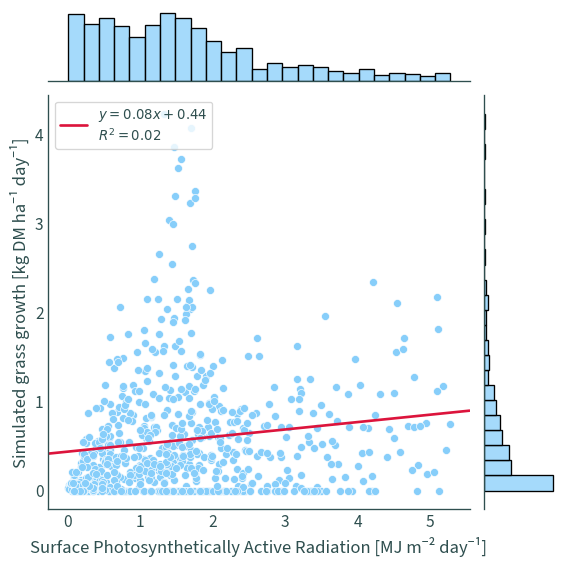

Variable: PET
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.278
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.132
Time:                        00:59:34   Log-Likelihood:                -700.05
No. Observations:                 691   AIC:                             1404.
Df Residuals:                     689   BIC:                             1413.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5269      0.038     1

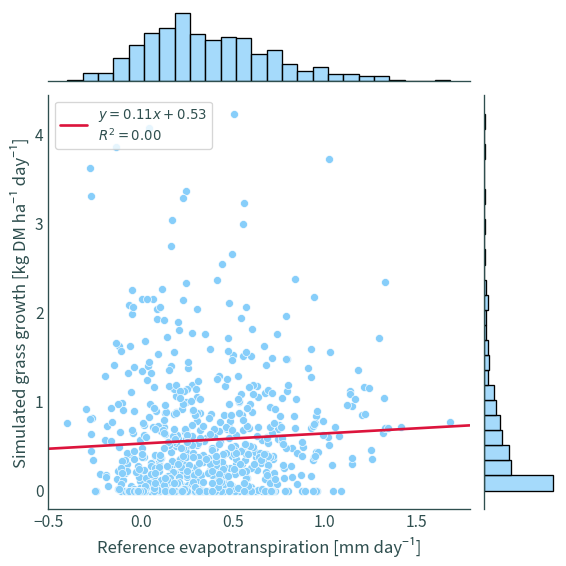

Variable: T
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.621
Date:                Tue, 12 Dec 2023   Prob (F-statistic):             0.0319
Time:                        00:59:35   Log-Likelihood:                -698.88
No. Observations:                 691   AIC:                             1402.
Df Residuals:                     689   BIC:                             1411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4585      0.057      8.

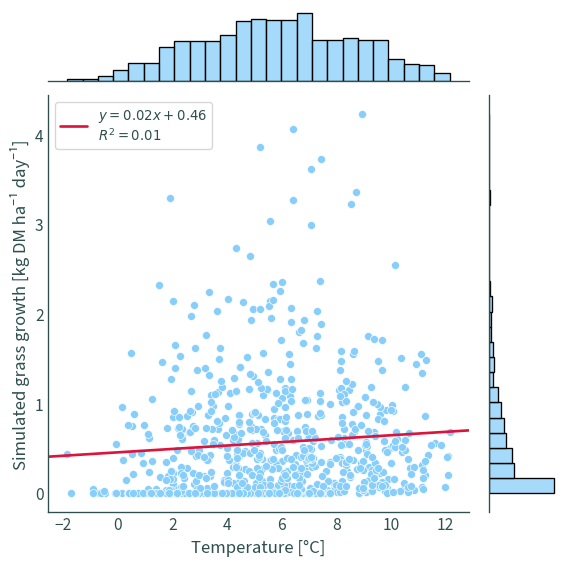

Variable: PP
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.52
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           9.00e-05
Time:                        00:59:35   Log-Likelihood:                -693.49
No. Observations:                 691   AIC:                             1391.
Df Residuals:                     689   BIC:                             1400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6271      0.029     21

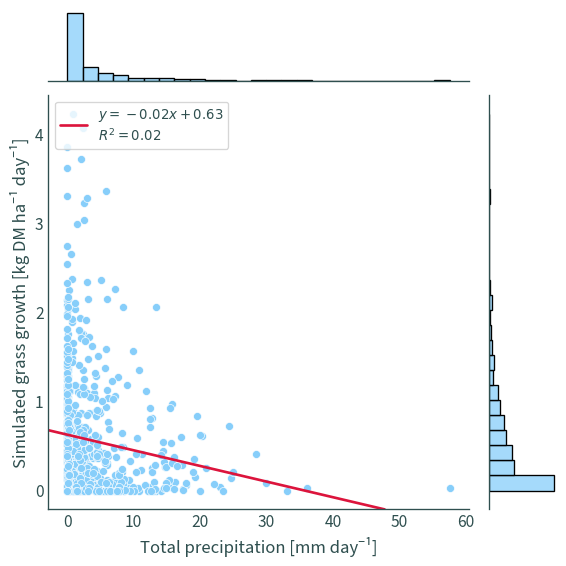

In [22]:
for var in ds.data_vars:
    print("Variable:", var)
    get_linear_regression(ts, ds, var, "gro", "DJF")

### Autumn

Variable: PAR
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     4815.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.26e-298
Time:                        01:00:16   Log-Likelihood:                -2044.5
No. Observations:                 637   AIC:                             4093.
Df Residuals:                     635   BIC:                             4102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0197      0.411     -

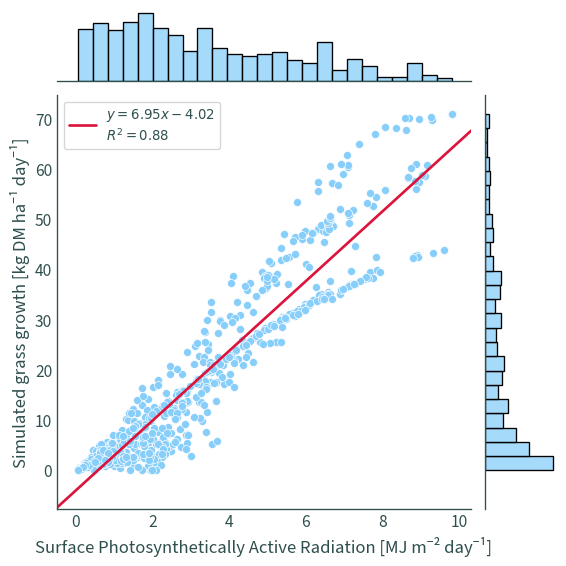

Variable: PET
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     1377.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          3.47e-161
Time:                        01:00:17   Log-Likelihood:                -2361.9
No. Observations:                 637   AIC:                             4728.
Df Residuals:                     635   BIC:                             4737.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8577      0.631      

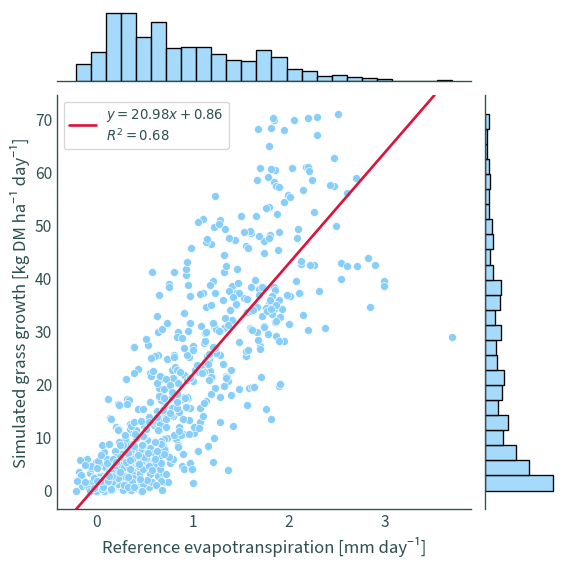

Variable: T
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     159.9
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           7.62e-33
Time:                        01:00:17   Log-Likelihood:                -2657.7
No. Observations:                 637   AIC:                             5319.
Df Residuals:                     635   BIC:                             5328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3259      1.888     -1.

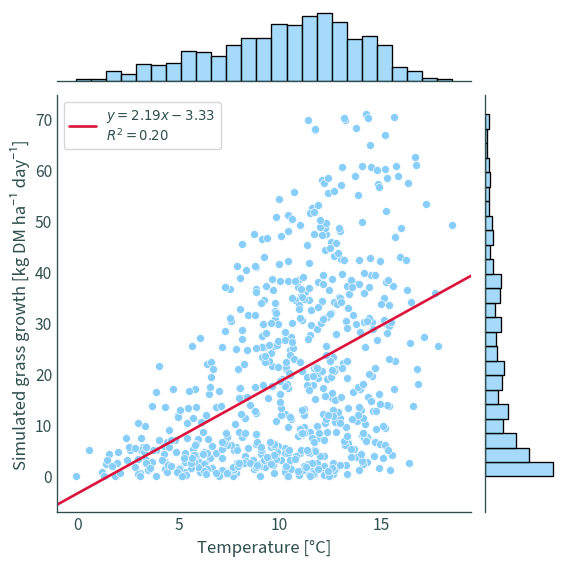

Variable: PP
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     61.17
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.18e-14
Time:                        01:00:17   Log-Likelihood:                -2699.9
No. Observations:                 637   AIC:                             5404.
Df Residuals:                     635   BIC:                             5413.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7182      0.739     29

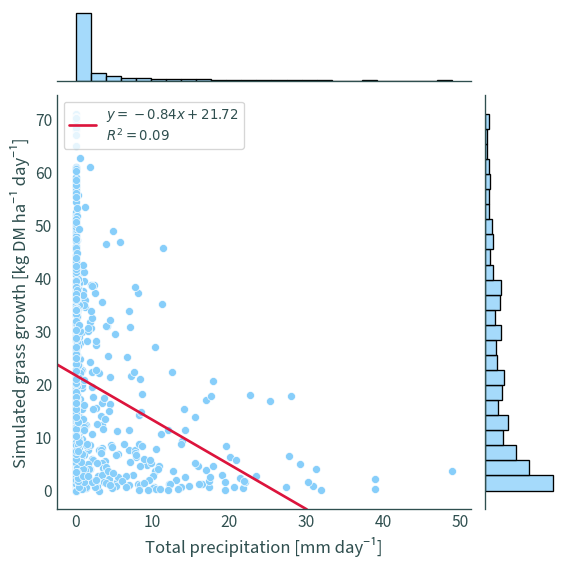

In [23]:
for var in ds.data_vars:
    print("Variable:", var)
    get_linear_regression(ts, ds, var, "gro", "SON")

### Summer

Variable: PAR
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     158.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           5.82e-33
Time:                        01:02:56   Log-Likelihood:                -3283.6
No. Observations:                 736   AIC:                             6571.
Df Residuals:                     734   BIC:                             6580.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8490      2.045      

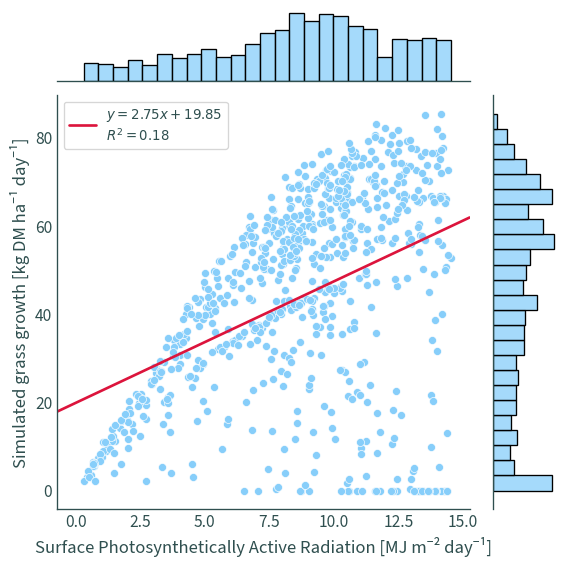

Variable: PET
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     49.98
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           3.63e-12
Time:                        01:02:56   Log-Likelihood:                -3331.2
No. Observations:                 736   AIC:                             6666.
Df Residuals:                     734   BIC:                             6676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2177      2.070     1

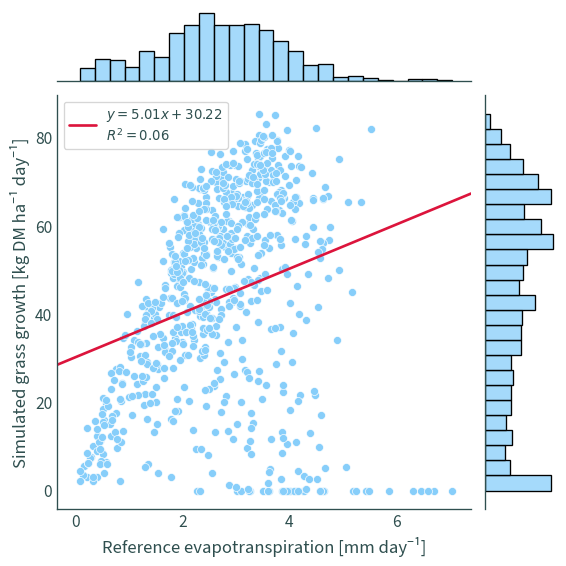

Variable: T
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     62.73
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           8.80e-15
Time:                        01:02:57   Log-Likelihood:                -3325.2
No. Observations:                 736   AIC:                             6654.
Df Residuals:                     734   BIC:                             6664.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.3995      5.336     16.

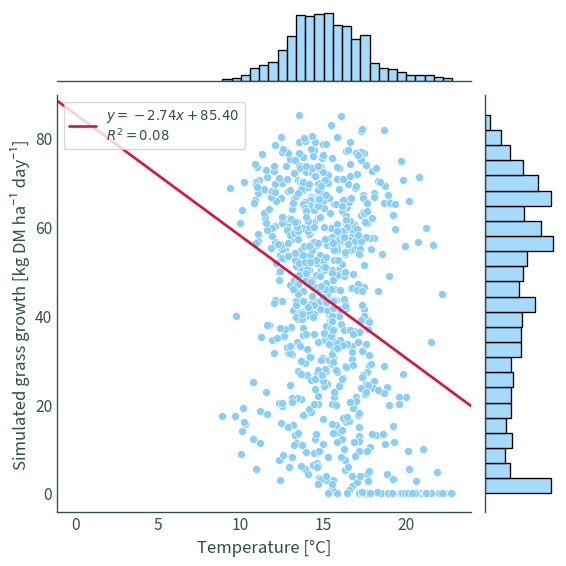

Variable: PP
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     38.71
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           8.27e-10
Time:                        01:02:57   Log-Likelihood:                -3336.5
No. Observations:                 736   AIC:                             6677.
Df Residuals:                     734   BIC:                             6686.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.0584      0.918     50

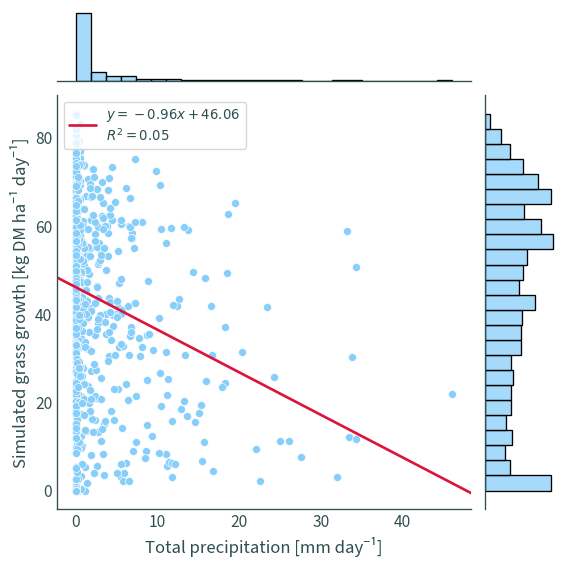

In [24]:
for var in ds.data_vars:
    print("Variable:", var)
    get_linear_regression(ts, ds, var, "gro", "JJA")

### Spring

Variable: PAR
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     358.6
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           3.46e-65
Time:                        01:04:09   Log-Likelihood:                -2933.8
No. Observations:                 721   AIC:                             5872.
Df Residuals:                     719   BIC:                             5881.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.7567      1.156     -

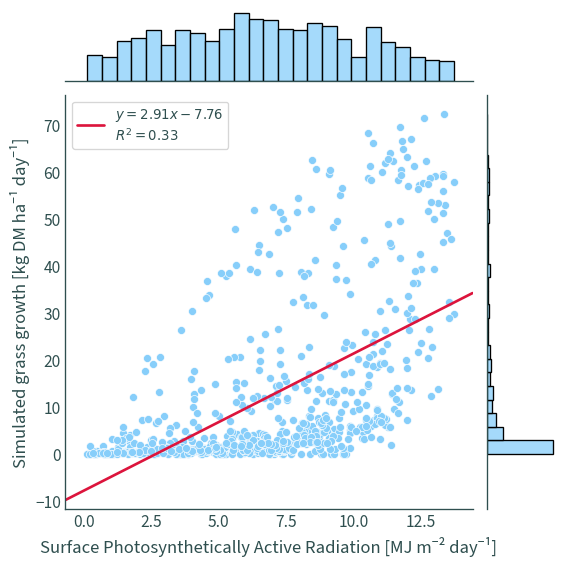

Variable: PET
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     668.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.12e-104
Time:                        01:04:10   Log-Likelihood:                -2842.8
No. Observations:                 721   AIC:                             5690.
Df Residuals:                     719   BIC:                             5699.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4107      0.907     -

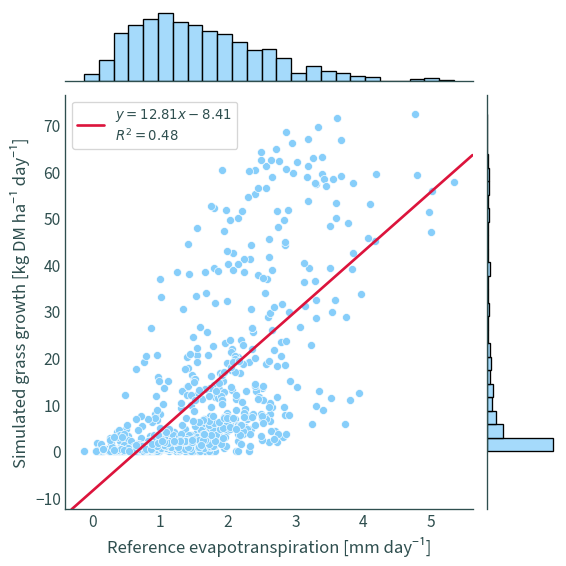

Variable: T
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     574.4
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           9.43e-94
Time:                        01:04:10   Log-Likelihood:                -2868.0
No. Observations:                 721   AIC:                             5740.
Df Residuals:                     719   BIC:                             5749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.2391      1.339    -13.

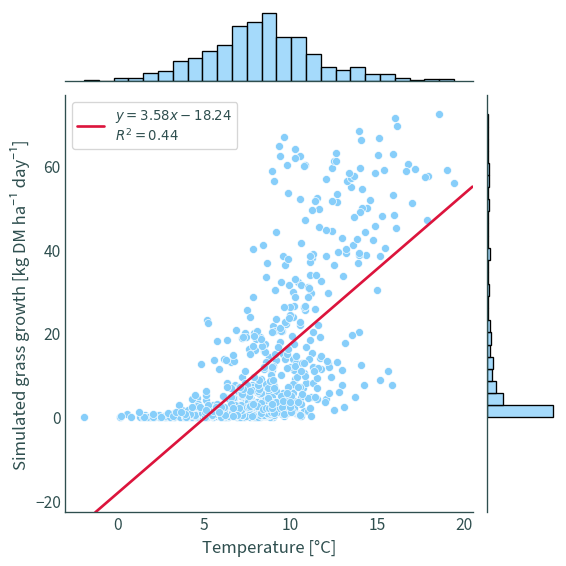

Variable: PP
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     27.61
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.96e-07
Time:                        01:04:10   Log-Likelihood:                -3066.1
No. Observations:                 721   AIC:                             6136.
Df Residuals:                     719   BIC:                             6145.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4607      0.716     18

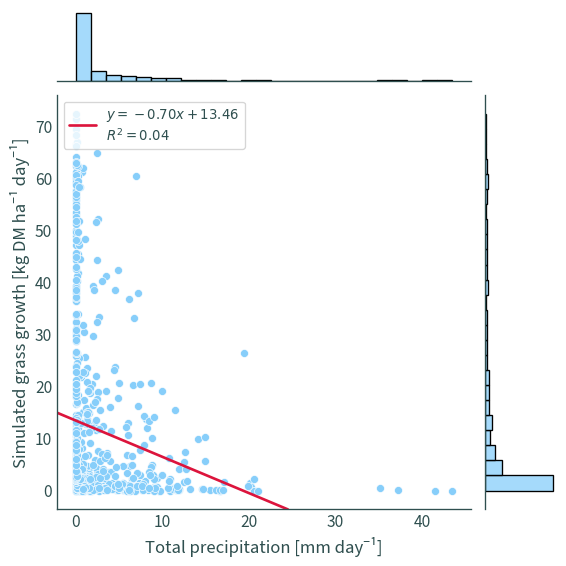

In [26]:
for var in ds.data_vars:
    print("Variable:", var)
    get_linear_regression(ts.dropna(), ds, var, "gro", "MAM")

### All seasons

Variable: PAR
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2378.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:04:46   Log-Likelihood:                -11873.
No. Observations:                2785   AIC:                         2.375e+04
Df Residuals:                    2783   BIC:                         2.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6406      0.536     -

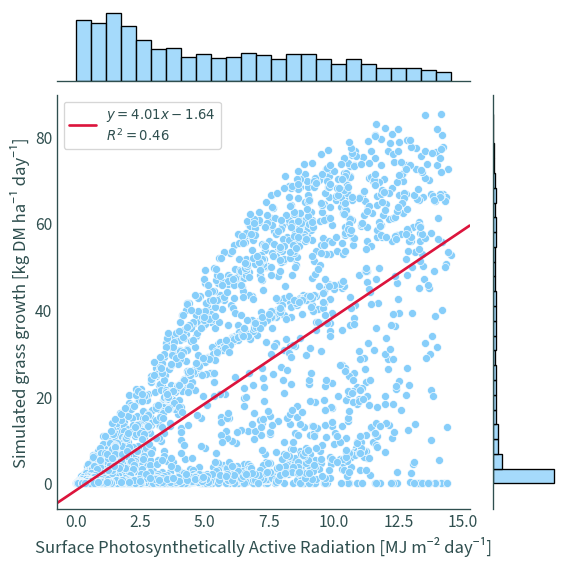

Variable: PET
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     2531.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:04:46   Log-Likelihood:                -11832.
No. Observations:                2785   AIC:                         2.367e+04
Df Residuals:                    2783   BIC:                         2.368e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5267      0.489      

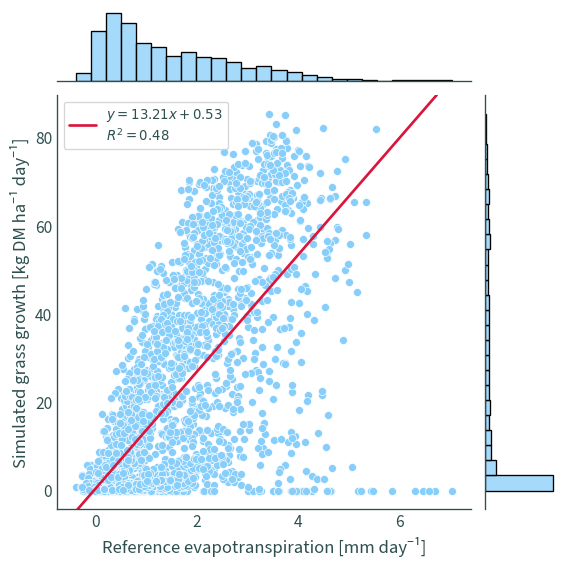

Variable: T
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1848.
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          4.29e-310
Time:                        01:04:46   Log-Likelihood:                -12024.
No. Observations:                2785   AIC:                         2.405e+04
Df Residuals:                    2783   BIC:                         2.406e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.6850      0.815    -15.

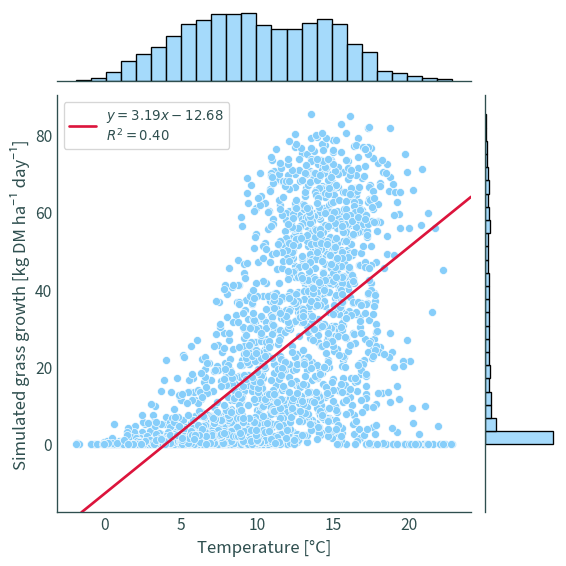

Variable: PP
                            OLS Regression Results                            
Dep. Variable:                    gro   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     89.43
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           6.51e-21
Time:                        01:04:47   Log-Likelihood:                -12689.
No. Observations:                2785   AIC:                         2.538e+04
Df Residuals:                    2783   BIC:                         2.539e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.2171      0.491     43

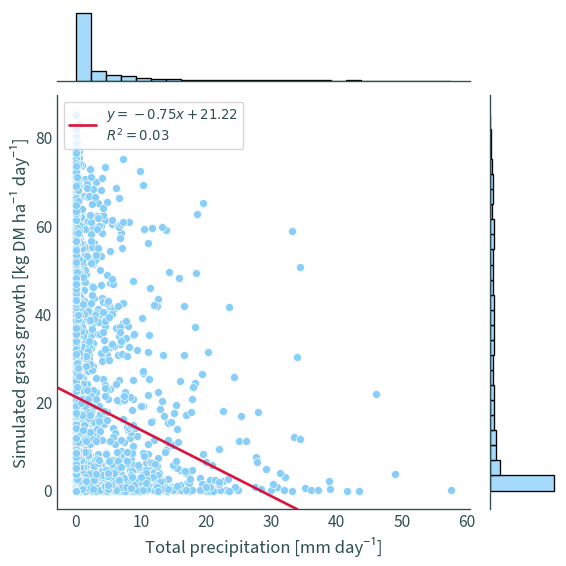

In [28]:
for var in ds.data_vars:
    print("Variable:", var)
    get_linear_regression(ts.dropna(), ds, var, "gro", None)